In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# --- Load Images ---
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# Function to load images
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load data
X, y = load_images_from_paths(paths)
y = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build VGG-19 Model ---
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, channels))
vgg_base.trainable = False  # Freeze the pre-trained layers

model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Train Model ---
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32)


58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/200
102/102 [==============================] - 16s 28ms/step - loss: 1.1019 - accuracy: 0.5715 - val_loss: 0.7478 - val_accuracy: 0.7444
Epoch 2/200
102/102 [==============================] - 2s 17ms/step - loss: 0.6713 - accuracy: 0.7722 - val_loss: 0.5886 - val_accuracy: 0.7988
Epoch 3/200
102/102 [==============================] - 2s 17ms/step - loss: 0.5572 - accuracy: 0.8070 - val_loss: 0.5301 - val_accuracy: 0.8284
Epoch 4/200
102/102 [==============================] - 2s 17ms/step - loss: 0.4970 - accuracy: 0.8336 - val_loss: 0.4858 - val_accuracy: 0.8358
Epoch 5/200
102/102 [==============================] - 2s 17ms/step - loss: 0.4540 - accuracy: 0.8481 - val_loss: 0.4792 - val_accuracy: 0.8395
Epoch 6/200
102/102 [==============================] - 2s 17ms/step - loss: 0.4179 - accuracy: 0.8626 - val_loss: 0.4381 - val_accuracy: 0.8407
Epoch 7/200
102/102 [==============================] - 2s 17ms/step - 

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Dự đoán trên tập test ---
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test, axis=1)
# --- Tính accuracy  ---
accuracy = np.sum(y_test_pred == y_test_true) / len(y_test_true)
print(f"Accuracy (manual calculation): {accuracy:.4f}")

# --- In báo cáo classification report: Precision, Recall, F1-score ---
report = classification_report(y_test_true, y_test_pred, target_names=[f"Class {i}" for i in range(num_classes)])
print("--- Classification Report ---")
print(report)


Accuracy (manual calculation): 0.8852
--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.93      0.89      0.91       179
     Class 1       0.81      0.82      0.81       164
     Class 2       0.85      0.85      0.85       173
     Class 3       0.95      0.94      0.95       139
     Class 4       0.90      0.94      0.91       155

    accuracy                           0.89       810
   macro avg       0.89      0.89      0.89       810
weighted avg       0.89      0.89      0.89       810



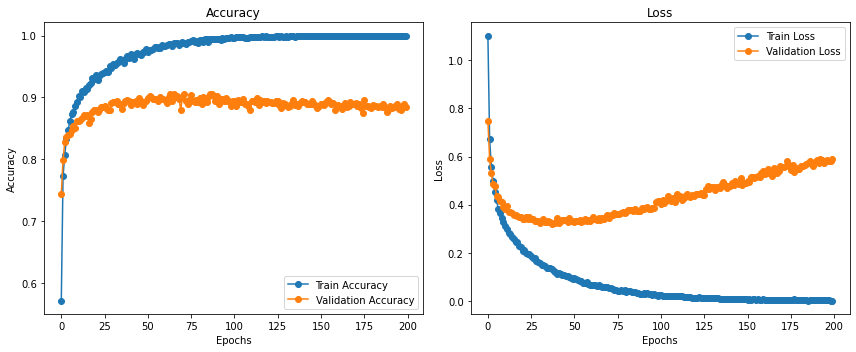

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


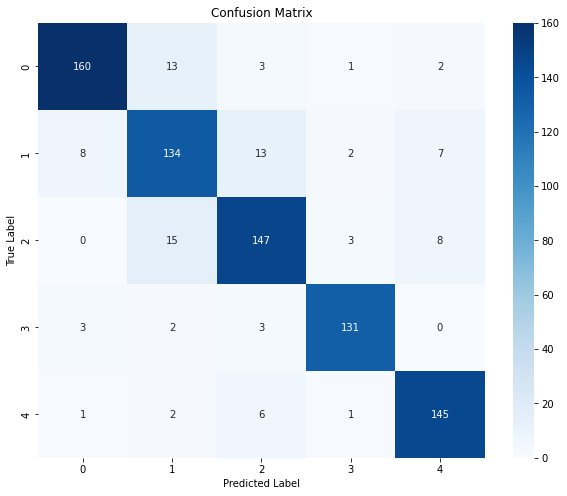

In [4]:
# --- Ma trận nhầm lẫn ---
y_test_int = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test_int, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

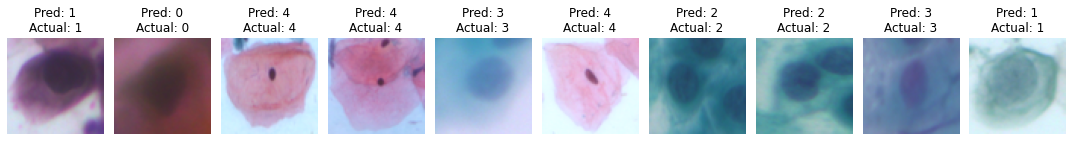

In [5]:
# --- Display Predictions ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10)
